<a href="https://colab.research.google.com/github/mevius6/smallgan-exp/blob/master/smallgan_exp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Установка

In [2]:
!git clone https://github.com/mevius6/smallgan-exp.git

Cloning into 'smallgan-exp'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 474 (delta 13), reused 40 (delta 3), pack-reused 390
Receiving objects: 100% (474/474), 117.16 MiB | 46.04 MiB/s, done.
Resolving deltas: 100% (88/88), done.


In [3]:
cd ./smallgan-exp/ml

/content/smallgan-exp/ml


[Основная контрольная точка для BigGAN](https://drive.google.com/open?id=1nAle7FCVFZdix2--ks0r5JBkFnKw8ctW), обученного в ImageNet с разрешением 128x128, с использованием [BS256](https://github.com/ajbrock/BigGAN-PyTorch/blob/master/scripts/sample_BigGAN_bs256x8.sh) и 8 градиентных накоплений, взятых перед коллапсом, с начальным показателем TF 97,35 +/- 1,79

In [4]:
!gdown https://drive.google.com/u/0/uc?id=1nAle7FCVFZdix2--ks0r5JBkFnKw8ctW

Downloading...
From: https://drive.google.com/u/0/uc?id=1nAle7FCVFZdix2--ks0r5JBkFnKw8ctW
To: /content/smallgan-exp/ml/BigGAN_ch96_bs256x8_138k.zip
2.00GB [00:20, 99.2MB/s]


In [5]:
!unzip BigGAN_ch96_bs256x8_138k.zip

Archive:  BigGAN_ch96_bs256x8_138k.zip
  inflating: 138k/D.pth              
  inflating: 138k/D_optim.pth        
  inflating: 138k/G.pth              
  inflating: 138k/G_ema.pth          
  inflating: 138k/G_optim.pth        
  inflating: 138k/state_dict.pth     


[Нужные веса](https://github.com/ajbrock/BigGAN-PyTorch/issues/8#issuecomment-477358969/) для генератора G.pth или G_ema.pth 

In [6]:
!mv 138k/G_ema.pth data/

## Обучение

In [9]:
!wget https://www.dropbox.com/s/2ahpj2a3ov9k2ng/checkpoint_iter60000.pth.tar

--2021-07-04 22:49:10--  https://www.dropbox.com/s/2ahpj2a3ov9k2ng/checkpoint_iter60000.pth.tar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.6.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.6.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2ahpj2a3ov9k2ng/checkpoint_iter60000.pth.tar [following]
--2021-07-04 22:49:10--  https://www.dropbox.com/s/raw/2ahpj2a3ov9k2ng/checkpoint_iter60000.pth.tar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc6bb738234781cbab40d6182d2d.dl.dropboxusercontent.com/cd/0/inline/BRov0kE3AJ6A2QWywgRaj3iZV5fJHLIJVF9652VxedNIrXnszS89u7MAp5Cr4X_bO8nV30_ggBx0LVEzSTOKOMMzHclRX1E-Axtz_1CJGhBvEpIthx9W7kcDgKWqLrtgbWZBQTY8SIa0PP7KVhQJwJrU/file# [following]
--2021-07-04 22:49:11--  https://uc6bb738234781cbab40d6182d2d.dl.dropboxusercontent.com/cd/0/inline/BRov0kE3AJ6A2QWywgRaj3iZV5fJHLIJVF9652Vxed

In [11]:
!python train.py --dataset rave --gpu 0 --pretrained ./data/G_ema.pth --resume "/content/smallgan-exp/ml/checkpoint_iter60000.pth.tar" --iters 500

gpu id: 0
using device: cuda:0
made the log directory ./experiments/train_dataset-rave_model-biggan128-ada_2021-07-04-23-20-13
cannot import gitpython; try pip install gitpython
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
number of images (dataset size):  25
model name: biggan128-ada
Adding attention layer in G at resolution 64
resuming trained weights from /content/smallgan-exp/ml/checkpoint_iter60000.pth.tar
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and la

## Тестирование



In [32]:
import glob
import os
import matplotlib
from PIL import Image
import numpy as np
import json

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision
from models.setup_model import setup_model
from dataloaders.setup_dataloader_smallgan import setup_dataloader


def reconstruct(model,out_path,indices):
    model.eval()
    device = next(model.parameters()).device
    dataset_size = model.embeddings.weight.size()[0]
    assert type(indices)==torch.Tensor
    indices = indices.to(device)        
    embeddings = model.embeddings(indices)
    batch_size = embeddings.size()[0]
    image_tensors = model(embeddings)
    with torch.no_grad():
        torchvision.utils.save_image(
            image_tensors,
            out_path,
            nrow=int(batch_size ** 0.5),
            normalize=True,
        )
        
# see https://github.com/nogu-atsu/SmallGAN/blob/2293700dce1e2cd97e25148543532814659516bd/gen_models/ada_generator.py#L37-L53
def interpolate(model,out_path,source,dist,trncate=0.4,num=5):
    model.eval()
    device = next(model.parameters()).device
    dataset_size = model.embeddings.weight.size()[0]
    indices = torch.tensor([source,dist],device=device)
    indices = indices.to(device) 
    embeddings = model.embeddings(indices)
    embeddings = embeddings[[0]] * torch.linspace(1, 0, num,device=device)[:, None] + embeddings[[1]]* torch.linspace(0, 1, num,device=device)[:, None]
    batch_size = embeddings.size()[0]
    image_tensors = model(embeddings)
    with torch.no_grad():
        torchvision.utils.save_image(
            image_tensors,
            out_path,
            nrow=batch_size,
            normalize=True,
        )

# from https://github.com/nogu-atsu/SmallGAN/blob/2293700dce1e2cd97e25148543532814659516bd/gen_models/ada_generator.py#L37-L53
def random(model,out_path,tmp=0.4, n=9, truncate=False):
    from scipy.stats import truncnorm
    model.eval()
    device = next(model.parameters()).device
    dataset_size = model.embeddings.weight.size()[0]
    dim_z = model.embeddings.weight.size(1)
    if truncate:
        embeddings = truncnorm(-tmp, tmp).rvs(n * dim_z).astype("float32").reshape(n, dim_z)
    else:
        embeddings = np.random.normal(0, tmp, size=(n, dim_z)).astype("float32")
    embeddings = torch.tensor(embeddings,device=device)
    batch_size = embeddings.size()[0]
    image_tensors = model(embeddings)
    with torch.no_grad():
        torchvision.utils.save_image(
            image_tensors,
            out_path,
            nrow=int(batch_size ** 0.5),
            normalize=True,
        )

In [13]:
dataloader = setup_dataloader("rave",batch_size=2)
dataset_size = len(dataloader.dataset)
exp_dir = "./experiments/train_dataset-rave_model-biggan128-ada_2021-07-04-23-20-13/"
print(json.load(open(exp_dir+"args.json")))
model = setup_model("biggan128-ada",dataset_size=25,resume=exp_dir+"checkpoint_iter500.pth.tar")
model = model.cuda()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'batch': 25, 'dataset': 'rave', 'eval_freq': 500, 'githash': None, 'gpu': '0', 'iters': 500, 'loss_dist_per': 'l2', 'loss_emd': 0.1, 'loss_norm_img': 1, 'loss_norm_per': 1, 'loss_per': 0.1, 'loss_re': 0.02, 'lr_bsa_l': 0.0005, 'lr_c_embed': 0.001, 'lr_embed': 0.05, 'lr_g_batch_stat': 0.0005, 'lr_g_l': 1e-07, 'model': 'biggan128-ada', 'pretrained': './data/G_ema.pth', 'print_freq': 100, 'resume': '/content/smallgan-exp/ml/checkpoint_iter60000.pth.tar', 'savedir': 'train', 'saveroot': './experiments', 'step': 3000, 'step_facter': 0.1, 'workers': 4}
model name: biggan128-ada
Adding attention layer in G at resolution 64
resuming trained weights from ./experiments/train_dataset-rave_model-biggan128-ada_2021-07-04-23-20-13/checkpoint_iter500.pth.tar


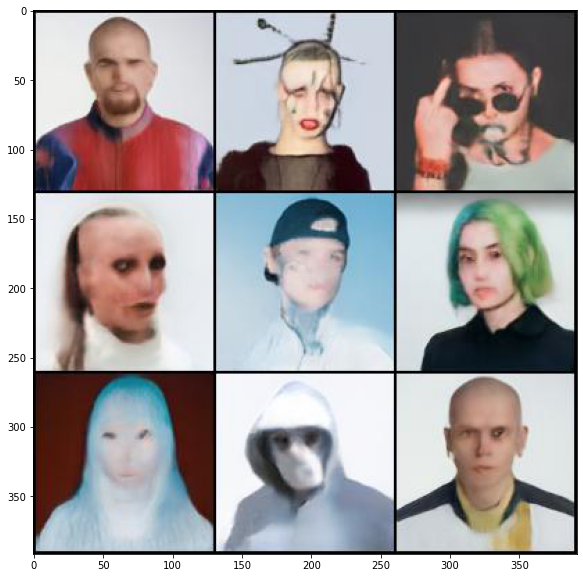

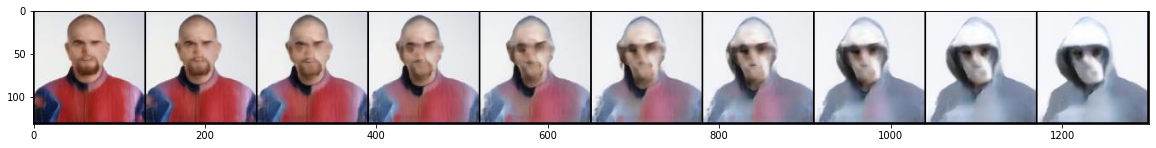

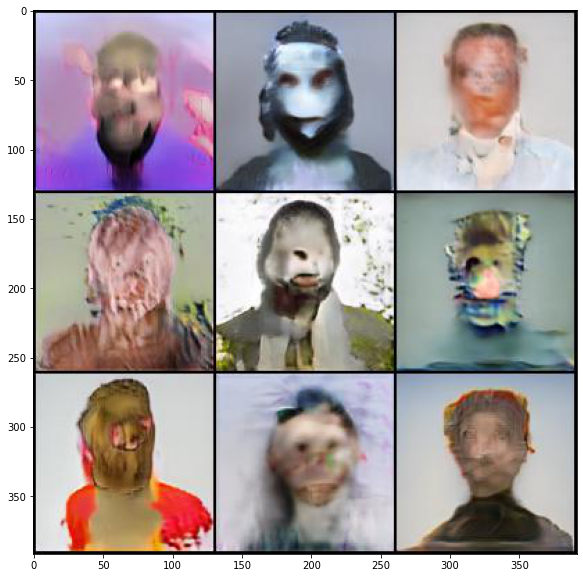

In [110]:
reconstruct(model,out_path="./samples/rave_reconstruct.jpg",indices= torch.arange(9))
interpolate(model,out_path="./samples/rave_interpolate.jpg",source=0,dist=7,num=10)
random(model,out_path="./samples/rave_random.jpg",tmp=0.82, n=9, truncate=True)

plt.figure(figsize=(10,10))
im = Image.open("./samples/rave_reconstruct.jpg")
plt.imshow(im)
plt.show()

plt.figure(figsize=(20,20))
im = Image.open("./samples/rave_interpolate.jpg")
plt.imshow(im)
plt.show()

plt.figure(figsize=(10,10))
im = Image.open("./samples/rave_random.jpg")
plt.imshow(im)
plt.show()

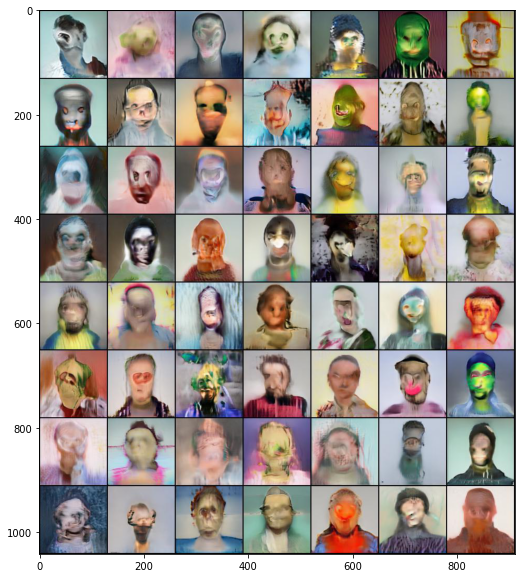

In [109]:
random(model,out_path="./samples/rave_random.jpg",tmp=0.85, n=56, truncate=True)

plt.figure(figsize=(10,10))
im = Image.open("./samples/rave_random.jpg")
plt.imshow(im)
plt.show()

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
uploaded = drive.CreateFile({'title': 'checkpoint_iter60500.pth.tar'})
uploaded.SetContentFile('./experiments/train_dataset-rave_model-biggan128-ada_2021-07-04-23-20-13/checkpoint_iter500.pth.tar')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

In [ ]:
uploaded = drive.CreateFile({'title': 'train-log.json'})
uploaded.SetContentFile('./experiments/train_dataset-rave_model-biggan128-ada_2019-06-01-07-22-28/train-log.json')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))